In [1]:
import wandb
import dgl

wandb.login()

wandb: Currently logged in as: ildarnikitin20. Use `wandb login --relogin` to force relogin


True

In [2]:
import numpy as np
import pandas as pd
import torch
from pathlib import Path
from tqdm import tqdm

f = np.load(str(Path('../data/features_(n_iterations, n_wells, n_dates, n_features).npy')))
t = np.load(str(Path('../data/targets_(n_iterations, n_wells, n_dates).npy')))

N_ITERATIONS, N_WELLS, N_DATES, N_FEATURES = f.shape
assert t.shape == (N_ITERATIONS, N_WELLS, N_DATES)

print(f.shape)
print(t.shape)

assert np.isnan(t).sum() == 0
print(np.isnan(f).sum() / np.prod(f.shape) * 100, '% NaNs')

for iteration in range(N_ITERATIONS):
    for well in range(N_WELLS):
        df = pd.DataFrame(f[iteration, well])
        f[iteration, well] = df.bfill().ffill().values
assert np.isnan(f).sum() == 0

f = torch.from_numpy(f).to(torch.float32)
t = torch.from_numpy(t).to(torch.float32)
t = t - t.mean(axis=0)

(884, 10, 114, 3)
(884, 10, 114)
15.263157894736842 % NaNs


In [3]:
N_LAGS = 25
edges = [(source_node, target_node) for source_node in range(N_WELLS)
                                    for target_node in range(N_WELLS)]

graphs = []
targets = []
data = []

for iteration in tqdm(range(f.shape[0])):
    for time in range(N_LAGS, N_DATES - N_LAGS):
        g = dgl.graph(edges, num_nodes = N_WELLS)
        g.ndata['emb'] = f[iteration, :, time - N_LAGS : time + N_LAGS + 1, :].reshape(N_WELLS, (2 * N_LAGS + 1) * 3)
        
        data.append((g, t[iteration, :, time]))
        targets.append(t[iteration, :, time])  
    

100%|████████████████████████████████████████████████████████████████████████████████| 884/884 [00:12<00:00, 68.74it/s]


In [4]:
targets = torch.from_numpy(np.vstack(targets)).to(torch.float32)

In [5]:
print(f"Количество графов {len(graphs)}")
assert len(graphs) == len(targets)

Количество графов 56576


In [6]:
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

train_data, test_data, train_targets, test_targets = train_test_split(data, targets, train_size=0.7, random_state=0)

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [7]:
from sklearn.metrics import mean_squared_error

BASELINE_RMSE = mean_squared_error(np.full_like(test_targets.reshape(-1), train_targets.mean()), 
                                   test_targets.reshape(-1), squared=False)
BASELINE_RMSE

2.4777358

In [8]:
def collate_fn_(batch):
    graphs, labels = zip(*batch)
    batched_graphs = dgl.batch(graphs)
    batched_labels = np.concatenate(labels, axis=0)
    return batched_graphs, batched_labels

In [9]:
BATCH_SIZE = 64

train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True,collate_fn=collate_fn_)
val_loader = DataLoader(test_data, batch_size=BATCH_SIZE,collate_fn=collate_fn_)

In [10]:
embs_dim = train_data[0][0].ndata['emb'].shape[1]
hidden_dim = 16
num_heads = 2

In [11]:
from dgl import nn as dgl_nn
from torch import nn

class GAT(nn.Module):
    def __init__(self, hidden_dim, num_heads):
        super(GAT, self).__init__()

        self.layer1 = dgl_nn.GATv2Conv(embs_dim, hidden_dim, num_heads)

        self.do1 = nn.Dropout(0.2)
        self.do2 = nn.Dropout(0.2)
        
        self.linear = nn.Sequential(
            nn.Linear(in_features=hidden_dim * num_heads, out_features=20),
            nn.ReLU(),
            nn.Linear(in_features=20, out_features=1),
        )
                
    def forward(self, graph):
        x_emb = graph.ndata['emb']

        h = x_emb
        
        h = self.layer1(graph, h)
        h = self.do1(h)
        
        h = torch.reshape(h, (h.shape[0], num_heads * hidden_dim))  
        
        graph.ndata['h'] = h

        h = self.linear(h)
        return h  

In [12]:
import torch
import matplotlib.pyplot as plt
from timeit import default_timer as timer
from IPython.display import clear_output


def train_loop(model, optimizer, criterion, train_loader) -> float:
    """
    Return RMSE
    """
    train_loss = 0.0
    model.train()
    for graphs, labels in train_loader:
        graphs = graphs.to(device)
        labels = torch.from_numpy(labels).to(torch.float32).to(device)
        optimizer.zero_grad()
        predictions = model(graphs).squeeze()
        loss = criterion(predictions.to(device), labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * BATCH_SIZE
    train_loss /= len(train_loader.dataset)
    return np.sqrt(train_loss)


@torch.no_grad()
def val_loop(model, criterion, val_loader) -> float:
    """
    Return RMSE
    """
    val_loss = 0.0
    model.eval()
    for graphs, labels in val_loader:
        graphs = graphs.to(device)
        labels = torch.from_numpy(labels).to(torch.float32).to(device)
        predictions = model(graphs).squeeze()
        loss = criterion(predictions.to(device), labels)
        val_loss += loss.item() * BATCH_SIZE
    val_loss /= len(val_loader.dataset)
    return np.sqrt(val_loss)


def plot(epochs: list[int], train_losses: list[float], val_losses: list[float], baseline_rmse: float, plot_baseline: bool):
    if plot_baseline:
        plt.axhline(baseline_rmse, linestyle='dashed', label='baseline')
    plt.plot(epochs, train_losses, label='train')
    plt.plot(epochs, val_losses, label='test')
    plt.title('RMSE')
    plt.ylabel('RMSE')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')
    plt.show()


def train_gnn(model, optimizer, criterion, scheduler, train_loader, val_loader, n_epochs: int, baseline_rmse: float, plot_baseline: bool):
    train_losses, val_losses = [], []
    lrs = []

    for epoch in range(1, n_epochs + 1):
        # Train
        start_time = timer()
        train_loss = train_loop(model, optimizer, criterion, train_loader)
        train_losses.append(train_loss)
        train_time = timer() - start_time

        # Validation
        start_time = timer()
        val_loss = val_loop(model, criterion, val_loader)
        val_losses.append(val_loss)
        val_time = timer() - start_time

        # Log lr
        lr = next(iter(optimizer.param_groups))['lr']
        lrs.append(lr)

        # Scheduler
        if scheduler is not None:
            scheduler.step(val_loss)

        # Log record
        record = {
            'train_loss': train_loss,
            'val_loss': val_loss,
            'lr': lr,
            'train_time': train_time,
            'val_time': val_time,
        }
        wandb.log(record)

        # Plot
        if epoch % 2 == 0:
            clear_output()
            print(f'Epoch={epoch}')
            print(f'val_RMSE={val_losses[-1]:.2f}; train_RMSE={train_losses[-1]:.2f}')
            print(f'lr={lr}')
            print(f'Train time: {train_time:.1f}s; val time: {val_time:.1f}s')
            epochs = list(range(1, epoch + 1))
            plot(epochs=epochs, train_losses=train_losses, val_losses=val_losses, baseline_rmse=baseline_rmse, plot_baseline=plot_baseline)
            start_plot_epoch = 10
            if epoch >= start_plot_epoch:
                plot(epochs=epochs[start_plot_epoch:], train_losses=train_losses[start_plot_epoch:], val_losses=val_losses[start_plot_epoch:], baseline_rmse=baseline_rmse, plot_baseline=plot_baseline)
            plt.plot(epochs, lrs)
            plt.title('LR')
            plt.xlabel('Epoch')
            plt.ylabel('LR')
            plt.show()
    wandb.finish()

In [13]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
assert device.type == 'cuda'
device

device(type='cuda', index=0)

Epoch=44
val_RMSE=2.48; train_RMSE=2.46
lr=0.001
Train time: 8.3s; val time: 2.0s


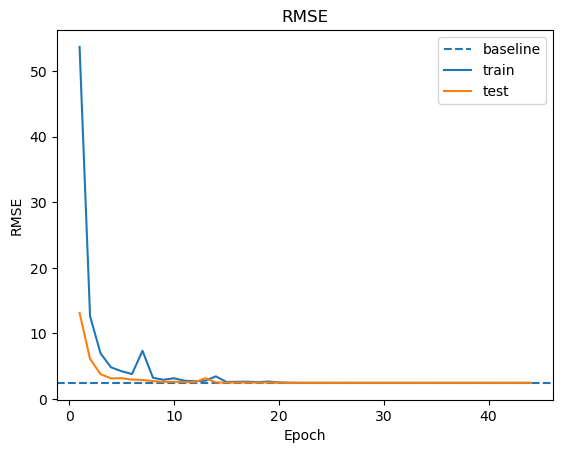

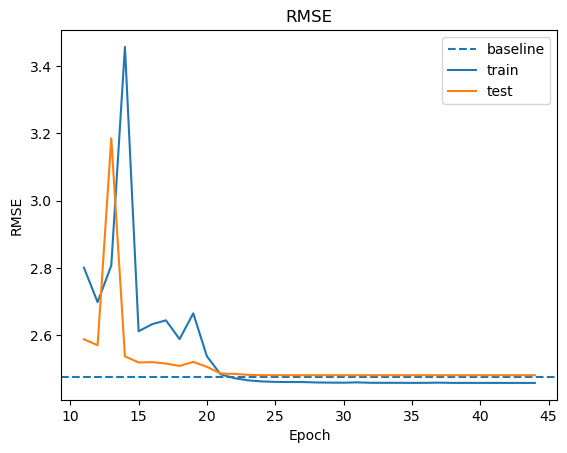

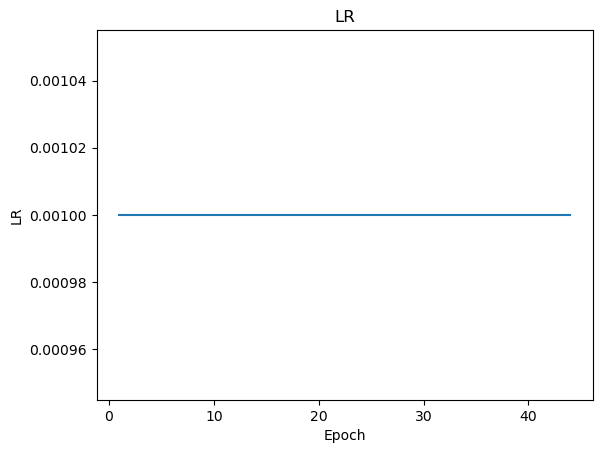

KeyboardInterrupt


lr,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_time,█▁▂▁▂▁▂▂▁▁▂▂▂▂▁▁▁▁▁▁▂▁▁▂▁▁▂▂▂▂▁▂▂▁▂▂▂▂▁▁
val_loss,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_time,█▂▂▃▁▃▂▁▂▃▃▃▁▂▂▄▁▂▁▃▁▂▃▃▁▂▃▃▃▃▂▃▂▃▃▃▃▂▂▂
lr,0.001
train_loss,2.4591
train_time,8.29296
val_loss,2.48199
val_time,1.98889


Success


In [14]:
N_EPOCHS = 1000
PATIENCE = 50
FACTOR = 0.3

KERNEL_SIZE = 10

model = GAT(hidden_dim, num_heads).to(device)

LR = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=PATIENCE, factor=FACTOR)
criterion = nn.MSELoss()
torch.manual_seed(0)

experiment_name = f'GAT'
notes = f'''
Optimizer: Adam({LR=})
Scheduler: ReduceLROnPlateau({PATIENCE=}, {FACTOR=})
{hidden_dim=};
'''

wandb.init(
    project='Oil neural network',
    name=experiment_name,
    notes=notes
)

try:
    train_gnn(model, optimizer, criterion, scheduler, train_loader=train_loader, val_loader=val_loader, n_epochs=N_EPOCHS, baseline_rmse=BASELINE_RMSE, plot_baseline=True)
except KeyboardInterrupt:
    print('KeyboardInterrupt')
    wandb.finish()

print('Success')